# ICESat-2 Data Tutorial
---
This notebook is designed to give you a first look at ICESat-2 data (the Ice, Cloud, and land Elevation Satellite, 2). There are a range of data products generated from the raw output of the instrument, which fall into categories defined by the processing level:

* L0 -- Reconstructed, unprocessed data at full resolution (no sane person would ever look at L0 data)
* L1 -- The same reconstructed, unprocessed data, but includes ancillary information (for example, calibration parameters and georeferencing information) and is often calibrated / converted to physical units (instead of instrument voltages, which are often the fundamental measurement).
* L2 [The lowest level we would ever look at] -- Derived geophysical parameters at the same resolution as the L1 data
* L3 [The most common level to use] -- Data, derived from L2 products, that has been spatially or temporally resampled, and analyzed for additional geophysical properties.

For our purposes here, we look at the following heirarchy of products
* ATL03 [L2] -- The time, latitude, longitude, and ellipsoidal height for each photon event downlinked from ATLAS.
* ATL06 [L3] -- The geolocated estimates of land-ice surface heights and ancillary parameters that can be used to interpret the estimates and assess their quality. Photon events are aggregated into overlapping, along-track segments of a fixed length (40 m) whose centers are 20 meters apart, and the algorithm estimates the along-track slope and height at the center of each segment. 
* ATL11 [L3] -- The time series of surface heights. It is the lowest-level land-ice product that brings together data from multiple passes over the same points, obviating the need to collect individual ATL06 files for this task.

<br><br>

To look at the data, I start by importing a series of modules that will be useful for reading and plotting the data. The ICESat-2 read functions come from Tyler Sutterly's github account (a current Postdoc at the University of Washington - https://github.com/tsutterley)

In [1]:
### sys and glob are useful tools for dealing with the local filesystem.
import sys   
import glob

### numpy and matplotlib are the core analysis packages for manipulating and plotting data arrays
import numpy as np
import matplotlib.pyplot as plt
import cmocean

### here, we import the local data read utilities from TS
sys.path.append('/mnt/data01/Code/Altimetry_Tools/read-ICESat-2/')

import icesat2_toolkit.utilities
from icesat2_toolkit.read_ICESat2_ATL03 import read_HDF5_ATL03
from icesat2_toolkit.read_ICESat2_ATL06 import read_HDF5_ATL06
from icesat2_toolkit.read_ICESat2_ATL11 import read_HDF5_ATL11

### finally, pyproj is a useful tool for converting geographic coordinates (lat/Lon) to local coordinate systems
from pyproj import Transformer

### this transformer object is designed to convert latitude/longitude to Antarctic Polarstereographic coordinates.
transformer = Transformer.from_crs("epsg:4326", "epsg:3031")

In [2]:
### In addition, we use something here called a Jupyter "Magick" -- this line changes the back-end of how Jupyter treats matplotlib plots.
### Instead of producing static images, the matplotlib widget allows you to zoom and pan and interrogate the plot interactively.
%matplotlib inline

# ATL03
---
As stated above, ATL03 is the geolocated photon product. Here are a few useful resources for understanding the structure of the files containing ATL03 data.

ATL03 Data Dictionary: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL03_data_dict_v004.pdf

ATL03 File Naming Convention: ATL03_[yyyymmdd][hhmmss]\_[ttttccss]\_[vvv_rr].h5


* tttt = Reference Ground Track (RGT)
* cc = Cycle
* ss = Region
* vvv_rr = Version and revision number

<br>
Here, I start by using `glob` to look in the local file directory for any files with names that start with "ATL03", and read in the first file in that list. The output of the read script is a tuple, which contains dictionaries for each file read. Because I want the `data` object to simply be a dictionary, I immediately select just the first entry in the tuple.

In [3]:
fn = glob.glob('ATL03*')
data_03 = read_HDF5_ATL03(fn[0])[0]
data_03.keys()

dict_keys(['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'ancillary_data', 'atlas_impulse_response'])

In [5]:
data_03.keys()
data_03['gt1l']['heights']['h_ph'].shape

(18091657,)

<br><br>
Exploring dictionaries often involves a lot of the `.keys` method -- remember, dictionaries store data as "key/value pairs", so if you want to see the different storage fields, those are listed as the `keys`. The data dictionary linked above provides text-definitions of each of the keys. 

In [6]:
data_03['gt1l']['heights'].keys()

dict_keys(['delta_time', 'dist_ph_across', 'dist_ph_along', 'h_ph', 'lat_ph', 'lon_ph', 'pce_mframe_cnt', 'ph_id_channel', 'ph_id_count', 'ph_id_pulse', 'quality_ph', 'signal_conf_ph'])

In [7]:
seg_cnt = np.array(data_03['gt1l']['geolocation']['segment_ph_cnt'])
seg_cnt = np.concatenate([np.atleast_1d(0),seg_cnt])
seg_cnt = np.cumsum(seg_cnt)


ref_index = np.zeros(data_03['gt1l']['heights']['signal_conf_ph'][:,4].shape,dtype=np.int32)
for i,ind_ref in enumerate(seg_cnt[:-1]):
    ref_index[ind_ref:seg_cnt[i+1]] = i

    
ph_x = data_03['gt1l']['heights']['dist_ph_along']+data_03['gt1l']['geolocation']['segment_dist_x'][ref_index]

<br><br>
Let's take a look at the photons, plotted in terms of their confidence classification

In [8]:
data_03['gt1l']['heights']['signal_conf_ph'][:,4]

array([-1, -1, -1, ...,  4,  4,  4], dtype=int8)

Text(0.5, 0, 'Distance Along Track (m)')

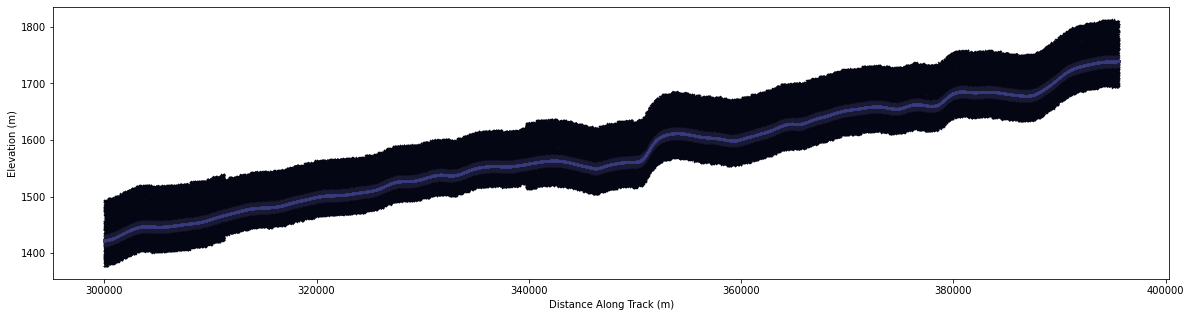

In [9]:
############ Here we define the limits to good data
start_xatc = 28500000

color_inds = np.uint16(np.linspace(0,256,12))
sizes = [0.1,0.2,0.4,0.9,1.5]
sizes = [1,1,1,1,1]
confs = [0,1,2,4]

############ And then we plot!
plt.figure(figsize=(20,5))

for i, conf_vals in enumerate(confs):
    keep_inds = np.where(np.all([[data_03['gt1l']['heights']['signal_conf_ph'][:,3] == conf_vals],[ph_x > 300000+start_xatc],[ph_x < 400000+start_xatc]],axis=0)[0])
    plt.plot(ph_x[keep_inds]-start_xatc,data_03['gt1l']['heights']['h_ph'][keep_inds],'.',ms=sizes[i],color=cmocean.cm.ice(color_inds[i]))

plt.ylabel('Elevation (m)')
plt.xlabel('Distance Along Track (m)')
#plt.xlim(300000,301000)
#plt.ylim(1420,1430)
 

In [10]:
data_03['gt1l']['heights']['signal_conf_ph'][:,4]


array([-1, -1, -1, ...,  4,  4,  4], dtype=int8)

In [11]:
data11['pt1']['quality_summary'][:,0]

NameError: name 'data11' is not defined

# ATL06
---
ATL06 uses a surface finding algorithm to determine the position and slope of the ice sheet surface.

ATL06 Data Dictionary: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL06_data_dict_v004.pdf

ATL06 File Naming Convention: ATL06_[yyyymmdd][hhmmss]\_[ttttccss]\_[vvv_rr].h5


* tttt = Reference Ground Track (RGT)
* cc = Cycle
* ss = Region
* vvv_rr = Version and revision number

<br><br>
As before, we read in the first file with a name starting "ATL06"

In [3]:
fn = glob.glob('ATL06*')
data_06 = read_HDF5_ATL06(fn[0])[0]
data_06.keys()

dict_keys(['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'quality_assessment', 'ancillary_data'])

In [4]:
data_06['gt1l'].keys()

dict_keys(['land_ice_segments'])

In [5]:
data_06['gt1l']['land_ice_segments'].keys()

dict_keys(['bias_correction', 'dem', 'fit_statistics', 'geophysical', 'ground_track', 'atl06_quality_summary', 'delta_time', 'h_li', 'h_li_sigma', 'latitude', 'longitude', 'segment_id', 'sigma_geo_h'])

In [6]:
data_06['gt1l']['land_ice_segments']['ground_track'].keys()

dict_keys(['ref_azimuth', 'ref_coelv', 'seg_azimuth', 'sigma_geo_at', 'sigma_geo_r', 'sigma_geo_xt', 'x_atc', 'y_atc'])

Text(0.5, 0, 'sample index')

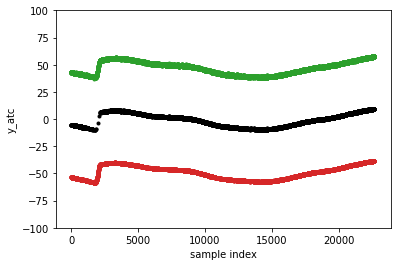

In [63]:
gts = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

si = 28200000
ei = 28800000
for i in gts:
    ki = np.where(np.all([data_06[i]['land_ice_segments']['ground_track']['x_atc'] > si, data_06[i]['land_ice_segments']['ground_track']['x_atc'] < ei],axis=0))
    plt.plot(data_06[i]['land_ice_segments']['ground_track']['y_atc'][ki],'.')
    
for i in range(0,2):
    d1 = data_06[gts[2*i]]['land_ice_segments']['ground_track']['y_atc']
    d2 = data_06[gts[2*i+1]]['land_ice_segments']['ground_track']['y_atc']
    d1[np.where(d1 > 10**10)] = np.NaN
    d2[np.where(d2 > 10**10)] = np.NaN
    d1[np.where(np.abs(d1) < 0.01)] = np.NaN
    d2[np.where(np.abs(d2) < 0.01)] = np.NaN
    
    ki1 = np.where(np.all([data_06[gts[2*i]]['land_ice_segments']['ground_track']['x_atc'] > si, data_06[gts[2*i]]['land_ice_segments']['ground_track']['x_atc'] < ei],axis=0))
    ki2 = np.where(np.all([data_06[gts[2*i+1]]['land_ice_segments']['ground_track']['x_atc'] > si, data_06[gts[2*i+1]]['land_ice_segments']['ground_track']['x_atc'] < ei],axis=0))
    
    mean_val =(d1[ki1][0:len(ki2[0])]+d2[ki2])/2
    plt.plot(mean_val,'.',color='black')

plt.ylim([-100,100])
plt.ylabel('y_atc')
plt.xlabel('sample index')



In [51]:
len(ki2[0])

20856

<br><br> 
Here, we can plot the fit segments on top of the ATL03 data, to demonstrate exactly where ATL06 comes from

Text(0.5, 0, 'Distance Along Track (m)')

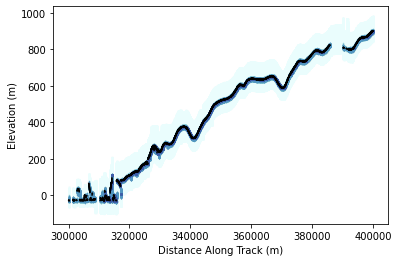

In [21]:

start_xatc = data_06['gt1l']['land_ice_segments']['ground_track']['x_atc'][0]

############ Here we regenerate the ATL03 plot
plt.figure()

color_inds = np.uint16(np.linspace(0,256,6))
sizes = [0.1,0.2,0.4,0.9,1.5]
sizes = [1,1,1,1,1]
confs = [0,1,2,4]
for i, conf_vals in enumerate(confs):
    keep_inds = np.where(np.all([[data_03['gt1l']['heights']['signal_conf_ph'][:,4] == conf_vals],[ph_x > 300000+start_xatc],[ph_x < 400000+start_xatc]],axis=0)[0])
    plt.plot(ph_x[keep_inds]-start_xatc,data_03['gt1l']['heights']['h_ph'][keep_inds],'.',ms=sizes[i],color=cmocean.cm.ice_r(color_inds[i]))


############ Here we define the limits to good data
keep_inds = np.where(np.all([[data_06['gt1l']['land_ice_segments']['atl06_quality_summary'] == 0],[data_06['gt1l']['land_ice_segments']['ground_track']['x_atc'] > 300000+start_xatc],[data_06['gt1l']['land_ice_segments']['ground_track']['x_atc'] < 400000+start_xatc]],axis=0)[0])

############ Here we build up the segment coordinates
at_x = np.squeeze(data_06['gt1l']['land_ice_segments']['ground_track']['x_atc'][keep_inds]-start_xatc)

at_x1 = at_x - 20;
at_x2 = at_x + 20;
at_y1 = data_06['gt1l']['land_ice_segments']['h_li'][keep_inds] - 20*data_06['gt1l']['land_ice_segments']['fit_statistics']['dh_fit_dx'][keep_inds]
at_y2 = data_06['gt1l']['land_ice_segments']['h_li'][keep_inds] + 20*data_06['gt1l']['land_ice_segments']['fit_statistics']['dh_fit_dx'][keep_inds]

############ We assemble the multidimensional array
at_x_final = np.array([[at_x1],[at_x2]]).squeeze()
at_y_final = np.array([[at_y1],[at_y2]]).squeeze()

plt.plot(at_x_final,at_y_final,color='black')

plt.ylabel('Elevation (m)')
plt.xlabel('Distance Along Track (m)')
#plt.xlim(340400,340600)
#plt.ylim(315,320)

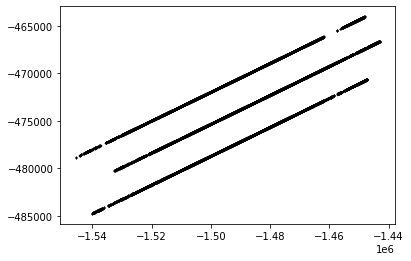

In [22]:
beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

plt.figure()
for i,beam_opts in enumerate(beams):
    x,y = transformer.transform(data_06[beam_opts]['land_ice_segments']['latitude'],data_06[beam_opts]['land_ice_segments']['longitude'])
    plt.plot(x[keep_inds],y[keep_inds],'.',ms=1,color='black')




# ATL11
---
ATL11 uses repeat observations of ATL06 to determine the height change through time. This uses each beam pair to determine the cross-track slope, to correct for height changes that are not due to changes in the glacier system but instead due to imprecision in the ground-track position.

ATL11 Data Dictionary: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL11_data_dict_v003.pdf

ATL11 File Naming Convention: ATL11_[tttt][ss]\_[cccc]\_[vvv_rr].h5


* tttt = Reference Ground Track (RGT)
* ss = Region
* cccc = First and last cycles of data included in the file
* vvv_rr = Version and revision number

In [13]:
fn = glob.glob('ATL11*')
data11 = read_HDF5_ATL11(fn[0])[0]
data11.keys()

dict_keys(['pt1', 'pt2', 'pt3', 'orbit_info', 'quality_assessment', 'ancillary_data'])

In [14]:
data11['pt1'].keys()

dict_keys(['cycle_number', 'delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'cycle_stats'])

In [15]:
data11['pt1']['h_corr'][1]

array([ 3.4028235e+38,  3.4028235e+38,  3.4028235e+38,  3.4028235e+38,
       -2.8647327e+01,  3.4028235e+38, -2.8306925e+01], dtype=float32)

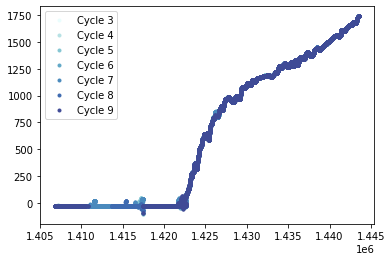

In [16]:
plt.figure()

color_inds = np.uint16(np.linspace(0,256,10))

for i,cycles in enumerate(data11['pt1']['cycle_number']):
    keep_inds = np.where(np.all([[data11['pt1']['quality_summary'][:,i] == 0],[data11['pt1']['h_corr'][:,i] < 1e4]],axis=0)[0])
    plt.plot(data11['pt1']['ref_pt'][keep_inds],np.squeeze(data11['pt1']['h_corr'][keep_inds,i]),'.',color=cmocean.cm.ice_r(color_inds[i]),label='Cycle '+str(cycles))
    
plt.legend()

In [9]:
import cmocean
import numpy as np
import matplotlib.pyplot as plt

opts = np.random.rand(5,10)
print(opts)

[[0.40320237 0.749546   0.90988106 0.53856011 0.80351217 0.14310991
  0.06071399 0.66931723 0.83778764 0.20311906]
 [0.48191316 0.53554421 0.26987357 0.43748337 0.41129757 0.9587206
  0.00281018 0.66456109 0.50022874 0.15887457]
 [0.78939713 0.03316012 0.98446977 0.10640022 0.87850232 0.90355416
  0.62128074 0.43006111 0.75016715 0.21104432]
 [0.78894955 0.44926165 0.16604711 0.92959798 0.09786877 0.09061384
  0.95461292 0.66379089 0.20390941 0.0742722 ]
 [0.44858146 0.70197252 0.89191885 0.04872815 0.83300978 0.50150616
  0.78580692 0.49508712 0.88140049 0.58418056]]


[0.40320237 0.749546   0.90988106 0.53856011 0.80351217 0.14310991
 0.06071399 0.66931723 0.83778764 0.20311906]
0
[0.48191316 0.53554421 0.26987357 0.43748337 0.41129757 0.9587206
 0.00281018 0.66456109 0.50022874 0.15887457]
1
[0.78939713 0.03316012 0.98446977 0.10640022 0.87850232 0.90355416
 0.62128074 0.43006111 0.75016715 0.21104432]
2
[0.78894955 0.44926165 0.16604711 0.92959798 0.09786877 0.09061384
 0.95461292 0.66379089 0.20390941 0.0742722 ]
3
[0.44858146 0.70197252 0.89191885 0.04872815 0.83300978 0.50150616
 0.78580692 0.49508712 0.88140049 0.58418056]
4


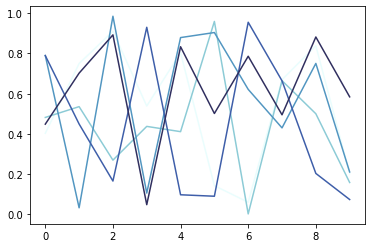

In [11]:
cmocean.cm.ice_r(0)

for ind,i in enumerate(opts):
    print(i)
    print(ind)
    
    plt.plot(i,color=cmocean.cm.ice_r(ind/len(opts)))